In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import sys

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow import keras

sys.path.append('..')
import data
import model
import utils
import preprocessing

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
params = utils.yaml_to_dict(os.path.join('..','config.yml'))
params['data_dir'] = os.path.join('..',params['data_dir'])
params['model_dir'] = os.path.join('..',params['model_dir'])

In [62]:
def load_model(params):
    #tf.keras.backend.clear_session()
    width, height = params['image_shape']
    inputs = tf.keras.layers.Input(shape=(width, height, 3))
    net = model.ModelArchitecture(num_classes=params['num_classes'])
    x = net(inputs, training=False)
    return net
    

def make_predictions(generator, params):
    
    net = load_model(params)
    
    optimizer = tf.keras.optimizers.Adam(lr=params['learning_rate'])
    net.compile(optimizer=optimizer, loss=params['loss'], metrics=['sparse_categorical_accuracy'])
    net.load_weights(os.path.join(params['model_dir'], 'tf_ckpt'))
    #predictions = net.predict(x=data_to_predict, batch_size=params['batch_size'], verbose=1)
    predictions = net.predict_generator(generator, steps=1)
    return np.argmax(predictions,axis=1)

In [163]:
def plot_results(data_to_predict,predictions, params):
    
    id_label_map = utils.load_id_label_map(params)
    
    fig, axis = plt.subplots(10,3, figsize=(15,15))
    
    images = data_to_predict[0]
    labels = data_to_predict[1]
    
    for i in range(10):
        k = np.random.randint(0,50)
        axis[i][0].imshow(images[k])
        axis[i][0].axis('off')

        label = id_label_map[labels[k]]
        axis[i][1].text(0.5, 0.5, label, size=25, ha="center", va="center",
                bbox=dict(
                    boxstyle="round",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                )
               )
        axis[i][1].set_title('Real')
        axis[i][1].axis('off')
        
        pred = id_label_map[predictions[k]]
        axis[i][2].text(0.5, 0.5, pred, size=25, ha="center", va="center",
                bbox=dict(
                    boxstyle="round",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                )
               )
        axis[i][2].set_title('Prediction')
        axis[i][2].axis('off')
            
        k += 1
    plt.show()

In [150]:
generator = data.make_datagenerator(params,mode='test')

params['batch_size'] = generator.n
params['shuffle'] = False

predictions = make_predictions(generator,params)

Found 50 images.


In [151]:
print(confusion_matrix(generator.data, predictions))
target_names = ["acelera", "arranca", "avanza", "derecha", "pita", "izquierda","frena", "detente", "retrocede", "gira", ]
print(classification_report(generator.data, predictions, target_names=target_names))

[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 1]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]
              precision    recall  f1-score   support

     acelera       1.00      1.00      1.00         5
     arranca       1.00      1.00      1.00         5
      avanza       1.00      1.00      1.00         5
     derecha       1.00      1.00      1.00         5
        pita       1.00      0.80      0.89         5
   izquierda       1.00      1.00      1.00         5
       frena       1.00      1.00      1.00         5
     detente       1.00      1.00      1.00         5
   retrocede       1.00      1.00      1.00         5
        gira       0.83      1.00      0.91         5

   micro avg       0.98      0.98      0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



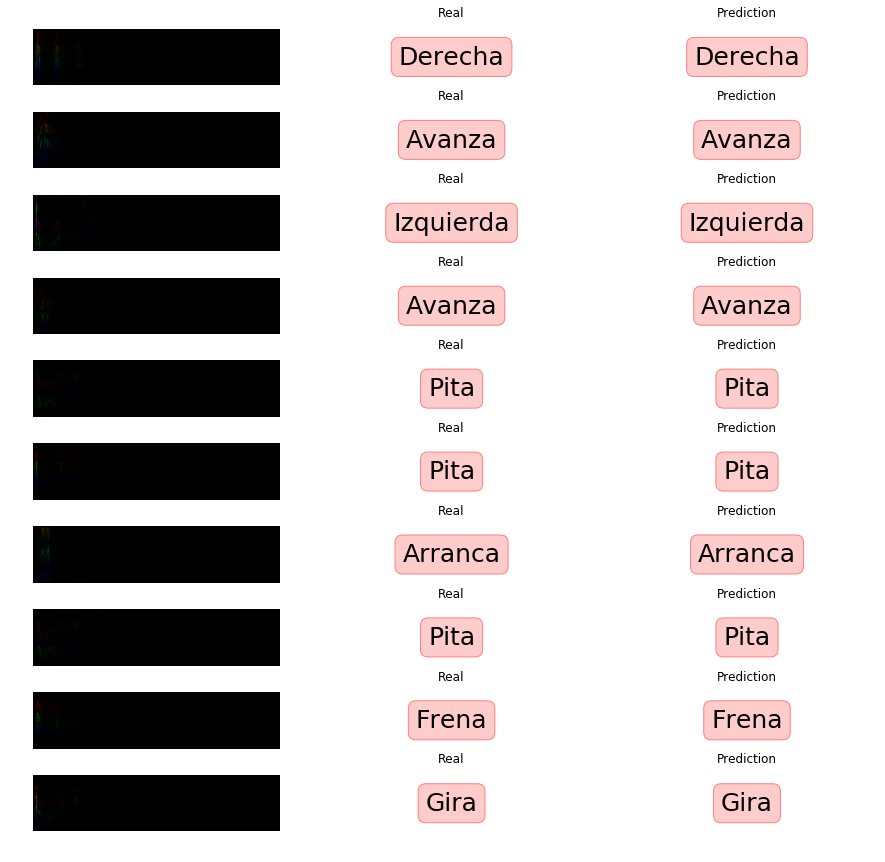

In [164]:
plot_results(next(generator),predictions, params)